<a href="https://colab.research.google.com/github/Kaybhee/Final_projectHamoyeHQ/blob/main/wildlife_synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd WildlifeQ2

/content/WildlifeQ2


In [ ]:
!ls

app.py	README.md  requirements.txt


In [ ]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15360 MiB, 15095 MiB


In [ ]:
!ls

app.py	README.md  requirements.txt


In [ ]:
!pip install torch==2.5.0
!pip install --upgrade torchaudio torchvision


In [ ]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers

In [ ]:
#@title Login to HuggingFace 🤗

#@markdown You need to accept the model license before downloading or using the Stable Diffusion weights. Please, visit the [model card](https://huggingface.co/runwayml/stable-diffusion-v1-5), read the license and tick the checkbox if you agree. You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work.
# https://huggingface.co/settings/tokens
!mkdir -p ~/.huggingface
HUGGINGFACE_TOKEN = "hf_token" #@param {type:"string"}
!echo -n "{HUGGINGFACE_TOKEN}" > ~/.huggingface/token

In [ ]:
#@markdown If model weights should be saved directly in google drive (takes around 4-5 GB).
save_to_gdrive = False #@param {type:"boolean"}
if save_to_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

#@markdown Name/Path of the initial model.
MODEL_NAME = "runwayml/stable-diffusion-v1-5" #@param {type:"string"}

#@markdown Enter the directory name to save model at.

OUTPUT_DIR = "stable_diffusion_weights/zwx" #@param {type:"string"}
if save_to_gdrive:
    OUTPUT_DIR = "/content/drive/MyDrive/" + OUTPUT_DIR
else:
    OUTPUT_DIR = "/content/" + OUTPUT_DIR

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

!mkdir -p $OUTPUT_DIR

[*] Weights will be saved at /content/stable_diffusion_weights/zwx


In [ ]:
concepts_list = [
      {
        "instance_prompt":      "photo of an african golden cat",
        "class_prompt":         "photo of an animal",
        "instance_data_dir":    "/content/data/african_golden_cat",
        "class_data_dir":       "/content/data/Animal_african_golden_cat"
    },
    {
        "instance_prompt":      "photo of African Manatee",
        "class_prompt":         "photo of an animal",
        "instance_data_dir":    "/content/data/African_manatee",
        "class_data_dir":       "/content/data/Animal_african_manatee"
    },
    {
        "instance_prompt":      "photo of African white backed vulture",
        "class_prompt":         "photo of an animal",
        "instance_data_dir":    "/content/data/white_backed_vulture",
        "class_data_dir":       "/content/data/Animal_white_backedVulture"
    }

]
import json
import os
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)

In [ ]:
import os
from google.colab import files
import shutil

for c in concepts_list:
    print(f"Uploading instance images for `{c['instance_prompt']}`")
    uploaded = files.upload()
    for filename in uploaded.keys():
        dst_path = os.path.join(c['instance_data_dir'], filename)
        shutil.move(filename, dst_path)

Uploading instance images for `photo of an african golden cat`


Saving 1.png to 1.png
Saving 2.png to 2.png
Saving 3.png to 3.png
Saving 4.png to 4.png
Uploading instance images for `photo of African Manatee`


Saving 1.png to 1.png
Saving 2.png to 2.png
Saving 3.png to 3.png
Saving 4.png to 4.png
Uploading instance images for `photo of African white backed vulture`


Saving 1.png to 1.png
Saving 2.png to 2.png
Saving 3.png to 3.png
Saving 4.png to 4.png


In [ ]:
!pip install bitsandbytes --upgrade


In [ ]:
!pip install --upgrade jax jaxlib diffusers

In [ ]:
!pip install --upgrade diffusers

In [ ]:
%pip install -U diffusers

In [ ]:
!python3 train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --revision="main" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=800 \
  --save_interval=10000 \
  --save_sample_prompt="photo of zwx dog" \
  --concepts_list="concepts_list.json"

In [ ]:
#@markdown Specify the weights directory to use (leave blank for latest)
WEIGHTS_DIR = "" #@param {type:"string"}
if WEIGHTS_DIR == "":
    from natsort import natsorted
    from glob import glob
    import os
    WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR + os.sep + "*"))[-1]
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")

[*] WEIGHTS_DIR=/content/stable_diffusion_weights/zwx/800


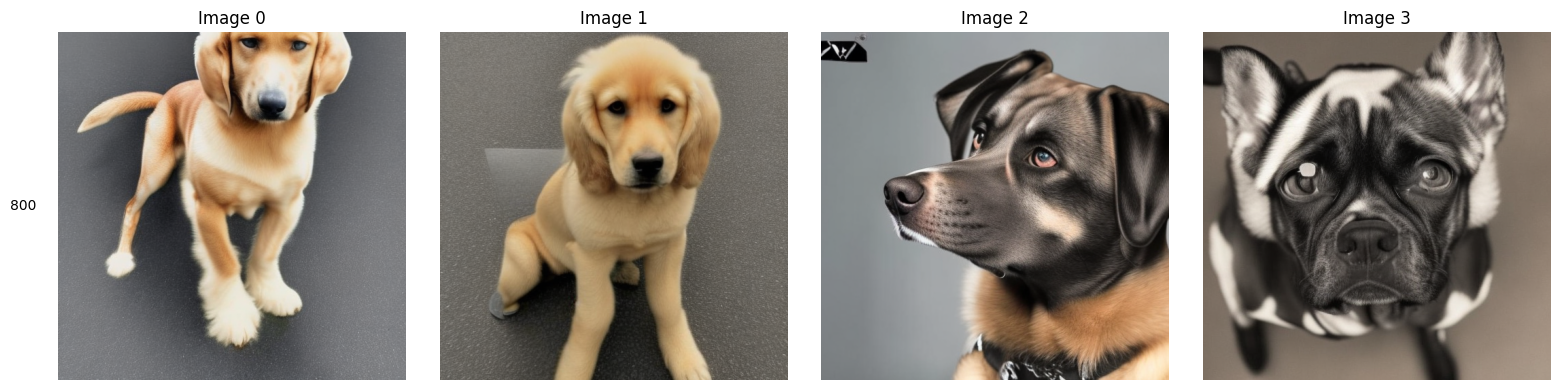

In [ ]:
#@markdown Run to generate a grid of preview images from the last saved weights.
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

weights_folder = OUTPUT_DIR
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key=lambda x: int(x))

row = len(folders)
col = len(os.listdir(os.path.join(weights_folder, folders[0], "samples")))
scale = 4
fig, axes = plt.subplots(row, col, figsize=(col*scale, row*scale), gridspec_kw={'hspace': 0, 'wspace': 0})

for i, folder in enumerate(folders):
    folder_path = os.path.join(weights_folder, folder)
    image_folder = os.path.join(folder_path, "samples")
    images = [f for f in os.listdir(image_folder)]
    for j, image in enumerate(images):
        if row == 1:
            currAxes = axes[j]
        else:
            currAxes = axes[i, j]
        if i == 0:
            currAxes.set_title(f"Image {j}")
        if j == 0:
            currAxes.text(-0.1, 0.5, folder, rotation=0, va='center', ha='center', transform=currAxes.transAxes)
        image_path = os.path.join(image_folder, image)
        img = mpimg.imread(image_path)
        currAxes.imshow(img, cmap='gray')
        currAxes.axis('off')

plt.tight_layout()
plt.savefig('grid.png', dpi=72)

In [ ]:
!ls

african_golden_cat  convert_diffusers_to_original_stable_diffusion.py  train_dreambooth.py
african_manatee     grid.png					       white_backed_vulture
app.py		    README.md
concepts_list.json  requirements.txt


In [ ]:
#@markdown Run conversion.
ckpt_path = WEIGHTS_DIR + "/model.ckpt"

half_arg = ""
#@markdown  Whether to convert to fp16, takes half the space (2GB).
fp16 = True #@param {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $WEIGHTS_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

[*] Converted ckpt saved at /content/stable_diffusion_weights/zwx/800/model.ckpt


#### Inference

In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

model_path = WEIGHTS_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

pipe = StableDiffusionPipeline.from_pretrained(model_path, safety_checker=None, torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
g_cuda = None

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [ ]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 52362 #@param {type:"number"}
g_cuda.manual_seed(seed)

  0%|          | 0/24 [00:00<?, ?it/s]

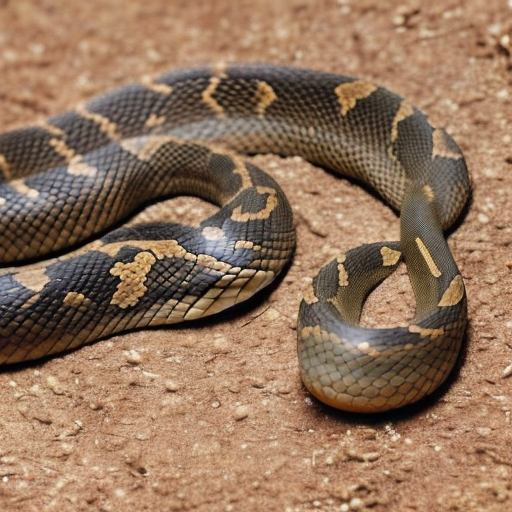

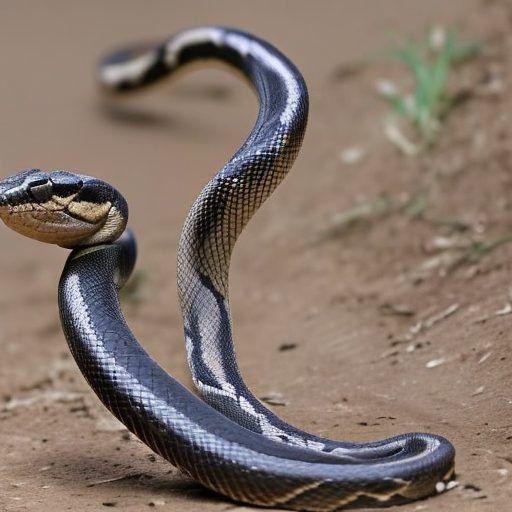

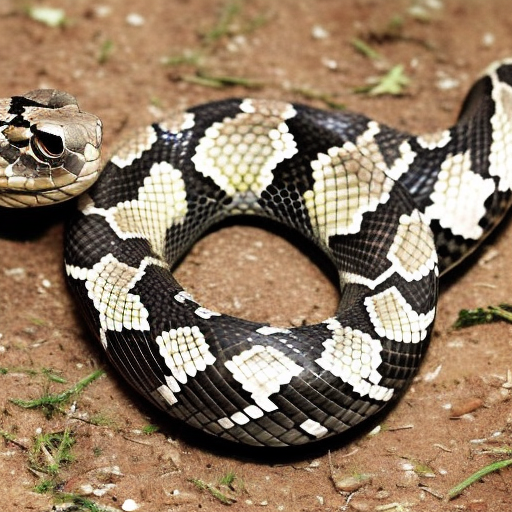

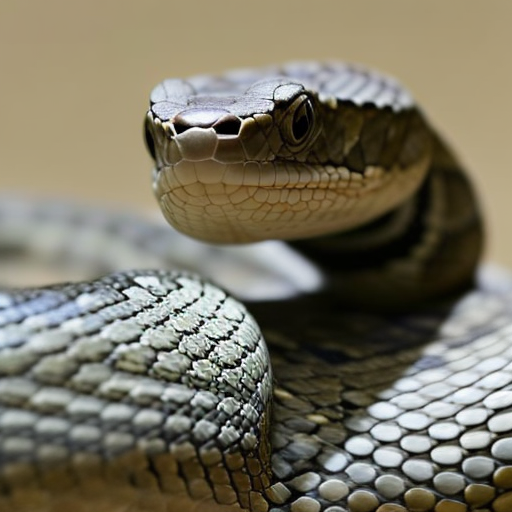

In [ ]:
#@title Run for generating images.

prompt = "photo of a snake" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
num_samples = 4 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 24 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

In [ ]:
#@title Run for generating images.

prompt = "photo of african golden cat" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
num_samples = 1 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 24 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

  0%|          | 0/24 [00:00<?, ?it/s]

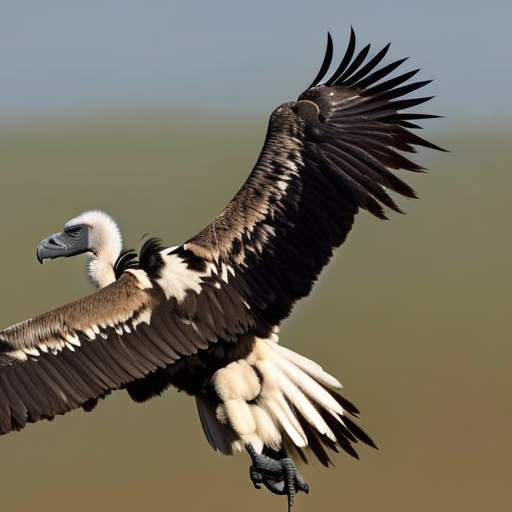

In [ ]:
#@title Run for generating images.

prompt = "photo of white backed vulture" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
num_samples = 1 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 24 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

In [ ]:
#@markdown Run Gradio UI for generating images.
import gradio as gr

def inference(prompt, negative_prompt, num_samples, height=512, width=512, num_inference_steps=50, guidance_scale=7.5):
    with torch.autocast("cuda"), torch.inference_mode():
        return pipe(
                prompt, height=int(height), width=int(width),
                negative_prompt=negative_prompt,
                num_images_per_prompt=int(num_samples),
                num_inference_steps=int(num_inference_steps), guidance_scale=guidance_scale,
                generator=g_cuda
            ).images

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="Prompt", value="photo of zwx dog in a bucket")
            negative_prompt = gr.Textbox(label="Negative Prompt", value="")
            run = gr.Button(value="Generate")
            with gr.Row():
                num_samples = gr.Number(label="Number of Samples", value=4)
                guidance_scale = gr.Number(label="Guidance Scale", value=7.5)
            with gr.Row():
                height = gr.Number(label="Height", value=512)
                width = gr.Number(label="Width", value=512)
            num_inference_steps = gr.Slider(label="Steps", value=24)
        with gr.Column():
            gallery = gr.Gallery()

    run.click(inference, inputs=[prompt, negative_prompt, num_samples, height, width, num_inference_steps, guidance_scale], outputs=gallery)

demo.launch(debug=True)

In [ ]:
!git add .

In [ ]:
!git config --global user.email "abdulkabirbadru@gmail.com"

!git config --global user.name "Kaybhee"


In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()
!git commit -m "all"

[main 66cf984] all
 17 files changed, 1253 insertions(+)
 create mode 100644 .gradio/certificate.pem
 create mode 100644 african_golden_cat/1.png
 create mode 100644 african_golden_cat/2.png
 create mode 100644 african_golden_cat/3.png
 create mode 100644 african_golden_cat/4.png
 create mode 100644 african_manatee/1.png
 create mode 100644 african_manatee/2.png
 create mode 100644 african_manatee/3.png
 create mode 100644 african_manatee/4.png
 create mode 100644 concepts_list.json
 create mode 100644 convert_diffusers_to_original_stable_diffusion.py
 create mode 100644 grid.png
 create mode 100644 train_dreambooth.py
 create mode 100644 white_backed_vulture/1.png
 create mode 100644 white_backed_vulture/2.png
 create mode 100644 white_backed_vulture/3.png
 create mode 100644 white_backed_vulture/4.png


In [ ]:
!pip install huggingface_hub


In [ ]:
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
The token `wildlife_img` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `wildlife_im

In [ ]:
!ls

african_golden_cat  convert_diffusers_to_original_stable_diffusion.py  train_dreambooth.py
african_manatee     grid.png					       white_backed_vulture
app.py		    README.md
concepts_list.json  requirements.txt


In [ ]:
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write

In [ ]:
!git remote set-url origin https://huggingface.co/spaces/Kaybhee/WildlifeQ2.git


In [ ]:
!git remote -v

origin	https://huggingface.co/spaces/Kaybhee/WildlifeQ2.git (fetch)
origin	https://huggingface.co/spaces/Kaybhee/WildlifeQ2.git (push)


In [ ]:
# !git add .
# !git commit -m "My update"
# !git push origin main
!git push origin main

Enumerating objects: 24, done.
Counting objects: 100% (24/24), done.
Delta compression using up to 2 threads
Compressing objects: 100% (22/22), done.
Writing objects: 100% (23/23), 5.31 MiB | 3.29 MiB/s, done.
Total 23 (delta 0), reused 0 (delta 0), pack-reused 0
To https://huggingface.co/spaces/Kaybhee/WildlifeQ2.git
   0755f5e..66cf984  main -> main
